In [22]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from models.prepareData import getData, convertData, calcMinimumMaximum
from models.models import linearRegressionModel, PolynomialFeatures, polynomialRegression

In [23]:
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Thọ', 'Phước Kiển', 'Nhà Bè')
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Cảnh', '22', 'Bình Thạnh')
# data = getData('Bán đất', 'Trần Văn Giàu', 'Lê Minh Xuân', 'Bình Chánh')
# data = getData('Bán đất', 'Vườn Lài', 'An Phú Đông', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán nhà riêng', 'Phạm Văn Chiêu', '9', 'Gò Vấp')
# data = getData('Bán nhà riêng', 'Nguyễn Văn Quá', 'Đông Hưng Thuận', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán đất', 'Nguyễn Thị Rành', 'Nhuận Đức', 'Củ Chi')
# data = getData('Bán đất', 'Tôn Đản', '10', '4')
data = getData('Bán căn hộ chung cư', '9A', 'Bình Hưng', 'Bình Chánh')

In [24]:
len(data)

97

In [25]:
post_type = data['post_type'].iloc[0]
street = data['street'].iloc[0]
ward = data['ward'].iloc[0]
district = data['district'].iloc[0]

In [26]:
print("Data length: ", len(data))

Data length:  97


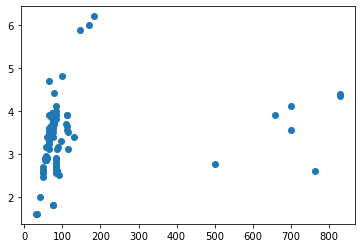

In [27]:
plt.scatter(data['area'], data['price'])
plt.show()

In [28]:
data = data[~(data['area'] < 10)]
data = data[~(data['price'] > 200)]

In [29]:
print("Data length: ", len(data))

Data length:  97


In [30]:
# transform data into log1p
data['area'] = (data['area']).transform(np.log1p)
data['price'] = (data['price']).transform(np.log1p)

In [31]:
# Instead of drop duplicates try calc and use its mean value:
data = data.groupby(['area'], as_index=False).mean()

# sort data by area:
data = data.sort_values(by=['area'])

In [32]:
area_mean = np.mean(data['area'])
area_std = np.std(data['area'])

price_mean = np.mean(data['price'])
price_std = np.std(data['price'])

data = data[~( (data['area'] < area_mean) & (data['price'] > price_mean) )]
data = data[~( (data['area'] > area_mean) & (data['price'] < price_mean - price_std) )]

In [33]:
# # remove outliers using box-plot:
# while True:
#     area_minimum, area_maximum = calcMinimumMaximum(data['area'])
#     if (data['area'] > area_minimum).all() and (data['area'] < area_maximum).all():
#         break
#     else:
#         data = data[(data['area'] > area_minimum) & (data['area'] < area_maximum)]

# while True:
#     price_minimum, price_maximum = calcMinimumMaximum(data['price'])
#     if (data['price'] > price_minimum).all() and (data['price'] < price_maximum).all():
#         break
#     else:
#         data = data[(data['price'] > price_minimum) & (data['price'] < price_maximum)]

In [34]:
# area_minimum, area_maximum = calcMinimumMaximum(data['area'])
# data = data[(data['area'] > area_minimum) & (data['area'] < area_maximum)]

# price_minimum, price_maximum = calcMinimumMaximum(data['price'])
# data = data[(data['price'] > price_minimum) & (data['price'] < price_maximum)]

In [35]:
# data = data[(data['area'] > 5.5)]

In [36]:
print("Data length: ", len(data))

Data length:  33


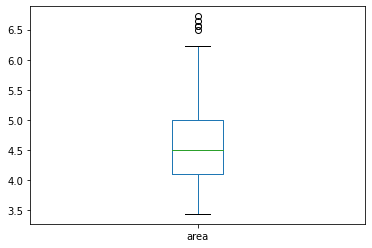

In [37]:
data['area'].plot(kind='box')
plt.show()

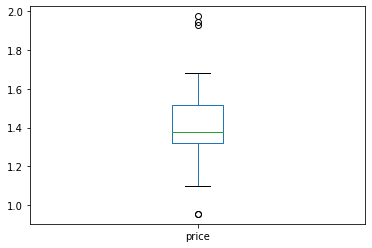

In [38]:
data['price'].plot(kind='box')
plt.show()

In [39]:
print("Data length: ", len(data))

Data length:  33


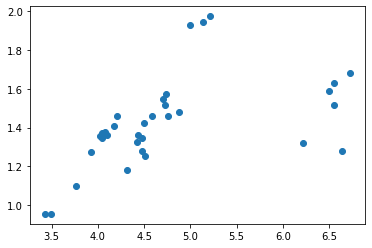

In [40]:
plt.scatter(data['area'], data['price'])
plt.show()

In [41]:
from sklearn.neighbors import LocalOutlierFactor

# convert dataframe into numpy array:
X = data.to_numpy()
n_neighbors = 10

In [42]:
X

array([[3.4339872 , 0.95551145],
       [3.49650756, 0.95551145],
       [3.76120012, 1.09861229],
       [3.93182563, 1.27677001],
       [4.02535169, 1.35452485],
       [4.04129534, 1.37410032],
       [4.04305127, 1.34807315],
       [4.07753744, 1.37738601],
       [4.09434456, 1.36097655],
       [4.17438727, 1.41098697],
       [4.20469262, 1.45861502],
       [4.31748811, 1.18028113],
       [4.41884061, 1.32820298],
       [4.4308168 , 1.36081956],
       [4.4750615 , 1.34651566],
       [4.47733681, 1.28093385],
       [4.49758498, 1.42551507],
       [4.51085951, 1.25276297],
       [4.58496748, 1.45861502],
       [4.70048037, 1.54756251],
       [4.72738782, 1.51512723],
       [4.73619845, 1.57177921],
       [4.75359019, 1.45753219],
       [4.87519732, 1.48160454],
       [4.99721227, 1.92861865],
       [5.14166356, 1.94591015],
       [5.20948615, 1.97408103],
       [6.22059017, 1.32175584],
       [6.49375384, 1.58923521],
       [6.55250789, 1.51512723],
       [6.


Outliers detected by Local Outlier Factor with n_neighbors =  10


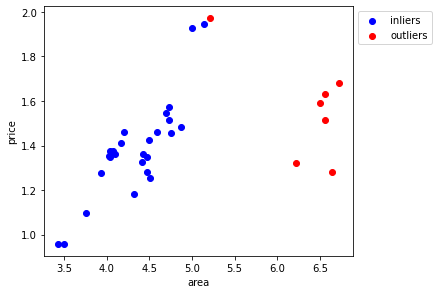

In [43]:
isNeighbors = LocalOutlierFactor(n_neighbors=n_neighbors, algorithm='brute', metric='euclidean', contamination=0.2).fit_predict(X)

# locate outliers by index:
outlier_indexes = np.where(isNeighbors == -1)
outlier_values = data.iloc[outlier_indexes]

# drop outliers:
data = data.drop(outlier_values.index)

print("\nOutliers detected by Local Outlier Factor with n_neighbors = ", n_neighbors)
# plot outliers removed:
plt.scatter(data['area'], data['price'], color='blue', label='inliers')
plt.scatter(outlier_values['area'], outlier_values['price'], color='red', label='outliers')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [44]:
# divide data into train and test:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=4)
test_data, validate_data = train_test_split(test_data, test_size=0.5, random_state=4)

In [45]:
# Sort data by area column:
train_data = train_data.sort_values(by=['area'])
test_data = test_data.sort_values(by=['area'])
validate_data = validate_data.sort_values(by=['area'])

print("\nTrain data length: ", len(train_data))
print("Test data length: ", len(test_data))
print("Validate data length: ", len(validate_data))


Train data length:  18
Test data length:  4
Validate data length:  4


In [46]:
# # convert data into numpy
X, Y = convertData(data)
X_train, Y_train = convertData(train_data)
X_test, Y_test = convertData(test_data)
X_validate, Y_validate = convertData(validate_data)

In [47]:
# scale data:

# Standard Scaler:

# X = StandardScaler().fit_transform(X)
# Y = StandardScaler().fit_transform(Y)

# X_train = StandardScaler().fit_transform(X_train)
# Y_train = StandardScaler().fit_transform(Y_train)

# X_test = StandardScaler().fit_transform(X_test)
# Y_test = StandardScaler().fit_transform(Y_test)

# X_validate = StandardScaler().fit_transform(X_validate)
# Y_validate = StandardScaler().fit_transform(Y_validate)


# Quantile Transformer:

# X = QuantileTransformer(n_quantiles=len(X_train), output_distribution='uniform').fit_transform(X)
# Y = QuantileTransformer(n_quantiles=len(Y_train), output_distribution='uniform').fit_transform(Y)

# X_train = QuantileTransformer(n_quantiles=len(X_train), output_distribution='uniform').fit_transform(X_train)
# Y_train = QuantileTransformer(n_quantiles=len(Y_train), output_distribution='uniform').fit_transform(Y_train)

# X_test = QuantileTransformer(n_quantiles=len(X_test), output_distribution='uniform').fit_transform(X_test)
# Y_test = QuantileTransformer(n_quantiles=len(X_test), output_distribution='uniform').fit_transform(Y_test)

# X_validate = QuantileTransformer(n_quantiles=len(X_validate), output_distribution='uniform').fit_transform(X_validate)
# Y_validate = QuantileTransformer(n_quantiles=len(Y_validate), output_distribution='uniform').fit_transform(Y_validate)

# Power Transformer:

# X = PowerTransformer(method='yeo-johnson').fit_transform(X)
# Y = PowerTransformer(method='yeo-johnson').fit_transform(Y)

# X_train = PowerTransformer(method='yeo-johnson').fit_transform(X_train)
# Y_train = PowerTransformer(method='yeo-johnson').fit_transform(Y_train)

# X_test = PowerTransformer(method='yeo-johnson').fit_transform(X_test)
# Y_test = PowerTransformer(method='yeo-johnson').fit_transform(Y_test)

# X_validate = PowerTransformer(method='yeo-johnson').fit_transform(X_validate)
# Y_validate = PowerTransformer(method='yeo-johnson').fit_transform(Y_validate)

# Log Transformer:

# X = FunctionTransformer(np.log1p).fit_transform(X)
# Y = FunctionTransformer(np.log1p).fit_transform(Y)

# X_train = FunctionTransformer(np.log1p).fit_transform(X_train)
# Y_train = FunctionTransformer(np.log1p).fit_transform(Y_train)

# X_test = FunctionTransformer(np.log1p).fit_transform(X_test)
# Y_test = FunctionTransformer(np.log1p).fit_transform(Y_test)

# X_validate = FunctionTransformer(np.log1p).fit_transform(X_validate)
# Y_validate = FunctionTransformer(np.log1p).fit_transform(Y_validate)

Text(0.5, 1.0, 'Y_validate')

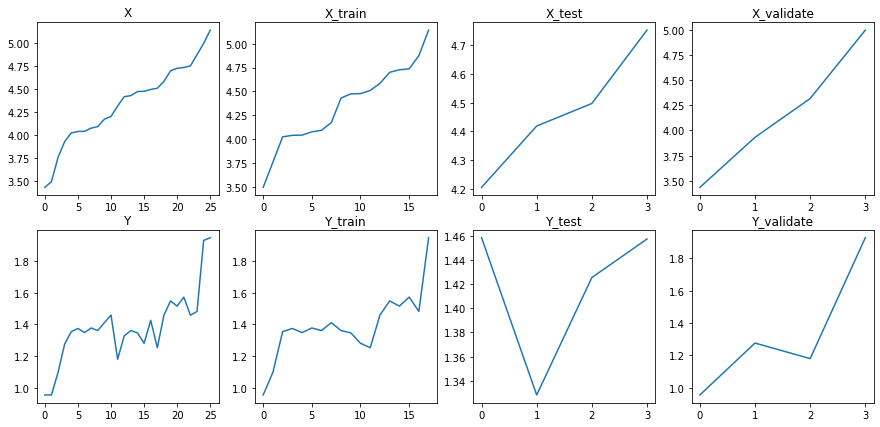

In [48]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0][0].plot(X)
ax[0][0].set_title('X')
ax[0][1].plot(X_train)
ax[0][1].set_title('X_train')
ax[0][2].plot(X_test)
ax[0][2].set_title('X_test')
ax[0][3].plot(X_validate)
ax[0][3].set_title('X_validate')

ax[1][0].plot(Y)
ax[1][0].set_title('Y')
ax[1][1].plot(Y_train)
ax[1][1].set_title('Y_train')
ax[1][2].plot(Y_test)
ax[1][2].set_title('Y_test')
ax[1][3].plot(Y_validate)
ax[1][3].set_title('Y_validate')

In [49]:
# find model by using linear regression:
linear_model = linearRegressionModel(X_train, Y_train)

# find Y by using linear model predict:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)

# Calculate RMSE on train and test data:
train_linear_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
test_linear_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))


Linear Regression Model: 


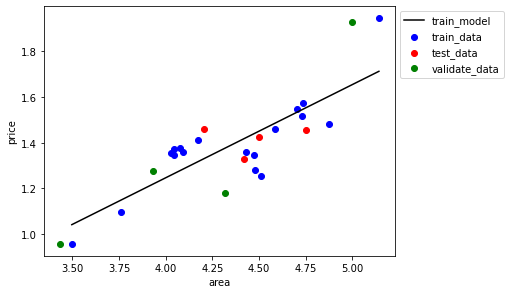

In [50]:
print("\nLinear Regression Model: ")
# Plot linear model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [51]:
# Linear Model coefficient and intercept:
print("Linear model coefficient: {}".format(linear_model.coef_))
print("Linear model intercept: {}".format(linear_model.intercept_))

# linear_model rmse:
print("Linear model rmse on train data: {}".format(train_linear_rmse))
print("Linear model rmse on test data: {}".format(test_linear_rmse))
print("\n\n")

Linear model coefficient: [[0.40716982]]
Linear model intercept: [-0.38164335]
Linear model rmse on train data: 0.10904107636626685
Linear model rmse on test data: 0.09259496416755021





In [52]:
# find model by using polynomial regression:
poly_model, poly_model_name, degree, validate_rmse = polynomialRegression(X_train, Y_train, X_validate, Y_validate, X_test, Y_test)

# transform X and X_test:
polynomial_features = PolynomialFeatures(degree=degree)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.fit_transform(X_test)

# Try predicting Y
Y_train_poly_pred = poly_model.predict(X_train_poly)
Y_test_poly_pred = poly_model.predict(X_test_poly)


Selected Polynomial Regression with degree = 23 and RMSE = 0.10130181382544276
Ridge Regression with alpha = 50.0 and RMSE = 0.3063247611631946
Lasso Model with alpha = 0.04 and RMSE = 0.3661384118328237
Selected Regularization Model is  Ridge


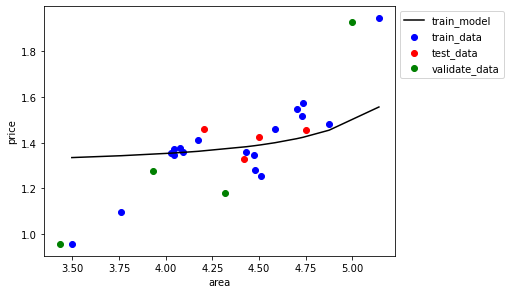

In [53]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_poly_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [54]:
print("Polynomial Regression with degree = {}\n".format(degree))
# Polynomial Model coefficient and intercept:
print("Polynomial model coefficient:")
print(poly_model.coef_)
print("Polynomial model intercept: {}\n".format(poly_model.intercept_))

# poly_model rmse:
# print("Polynomial Model RMSE on train data: {}".format(train_rmse))
print("Polynomial Model RMSE on validate data: {}".format(validate_rmse))
# print("Polynomial Model RMSE on test data: {}".format(test_rmse))

Polynomial Regression with degree = 23

Polynomial model coefficient:
[[0.00000000e+00 5.91970395e-03 6.81389470e-04 1.03468400e-04
  1.74976115e-05 3.12609064e-06 5.76473994e-07 1.08395545e-07
  2.06349324e-08 3.95934571e-09 7.63509842e-10 1.47685336e-10
  2.86171671e-11 5.55014105e-12 1.07676509e-12 2.08891275e-13
  4.05143740e-14 7.85487660e-15 1.52227626e-15 2.94899563e-16
  5.71079638e-17 1.10556363e-17 2.13974229e-18 4.14053924e-19]]
Polynomial model intercept: [1.29417053]

Polynomial Model RMSE on validate data: 0.3063247611631946


In [55]:
# score the model with test data:

# Linear score:
print("\n")

linear_train_r2_score = linear_model.score(X_train, Y_train)
print("Linear Model score on train dataset: ", linear_train_r2_score)

linear_test_r2_score = linear_model.score(X_test, Y_test)
print("Linear Model score on test dataset: ", linear_test_r2_score)

# Poly score:
print("\n")

poly_train_r2_score = poly_model.score(X_train_poly, Y_train)
print("Poly Model score on train dataset: ", poly_train_r2_score)

poly_test_r2_score = poly_model.score(X_test_poly, Y_test)
print("Poly Model score on test dataset: ", poly_test_r2_score)



Linear Model score on train dataset:  0.6975017128073346
Linear Model score on test dataset:  -2.026622464924925


Poly Model score on train dataset:  0.3737121757636974
Poly Model score on test dataset:  -0.227740987924272


In [56]:
# calc cross validation score of linear to compare with poly for best model selection
linear_cv = np.mean(cross_val_score(linear_model, X, Y, cv=5))
poly_cv = np.mean(cross_val_score(poly_model, X, Y, cv=5))

best_r2_score = linear_test_r2_score if linear_test_r2_score > poly_test_r2_score else poly_test_r2_score
best_model = linear_model if linear_cv > poly_cv else poly_model
best_degree = 1 if linear_cv > poly_cv else degree

print(linear_cv)
print(poly_cv)

-3.0830162047449337
-1.6605400267635377


In [57]:
import unidecode
post_type = unidecode.unidecode(post_type.lower().replace(" ", ""))
street = unidecode.unidecode(street.lower().replace(" ", ""))
ward = unidecode.unidecode(ward.lower().replace(" ", ""))
district = unidecode.unidecode(district.lower().replace(" ", ""))
model_name = post_type + "_" + street + "_" + ward + "_" + district

In [58]:
model_name

'bancanhochungcu_9a_binhhung_binhchanh'

In [59]:
# Save model after training for later use:
from joblib import dump, load

if best_r2_score > 0.7:
    # Save model:
    dump((best_model, best_degree), 'trained\\' + model_name + '.joblib')

In [60]:
try:    
    # load model:
    loaded_model, loaded_degree = load('trained/' + model_name + ".joblib")

    test_area = np.array([92.00])
    test_area = test_area[:, np.newaxis]
    test_area = FunctionTransformer(np.log1p).fit_transform(test_area)

    if loaded_degree == 1:
        predicted_price = loaded_model.predict(test_area)
    else:
        test_area_poly = PolynomialFeatures(degree=loaded_degree).fit_transform(test_area)
        predicted_price = loaded_model.predict(test_area_poly)

    print(FunctionTransformer(np.log1p).inverse_transform(predicted_price))
except FileNotFoundError:
    print("Model not found or trained result is low!")

Model not found or trained result is low!
